In [1]:
!pip install ogb
!pip install torch_geometric
!pip install scikit-network

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 30.7 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 9.7 MB/s eta 0:00:00:00:0100:01


In [2]:
import numpy as np
import copy
import json


from ogb.linkproppred import LinkPropPredDataset

dataset = LinkPropPredDataset(name = "ogbl-biokg")
graph = dataset[0]

Downloaded 0.90 GB: 100%|██████████| 920/920 [00:58<00:00, 15.73it/s]


Extracting dataset/biokg.zip
Loading necessary files...
This might take a while.
Processing graphs...


100%|██████████| 1/1 [00:00<00:00, 1781.02it/s]

Saving...


In [3]:
edge_index = graph["edge_index_dict"].copy()
old_keys = list(edge_index.keys())
for old_name in old_keys:
    new_name = "--".join(old_name)
    edge_index[new_name] = edge_index[old_name]
    del edge_index[old_name]

In [4]:
class NumpyEncoder(json.JSONEncoder):
    """ Special json encoder for numpy types """
    def default(self, obj):
        if isinstance(obj, (np.int_, np.intc, np.intp, np.int8,
                            np.int16, np.int32, np.int64, np.uint8,
                            np.uint16, np.uint32, np.uint64)):
            return int(obj)
        elif isinstance(obj, (np.float_, np.float16, np.float32,
                              np.float64)):
            return float(obj)
        elif isinstance(obj, (np.ndarray,)):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

In [5]:
edge_index_json = json.dumps(edge_index, cls = NumpyEncoder)

with open('./edge_index.json', 'a') as f:
    f.write(edge_index_json + '\n')

In [6]:
import json  
import pandas as pd  
import networkx as nx  
import os  
import random  
# Load JSON data  
with open('./edge_index.json', 'r') as f:  
    biokg = json.load(f)  

# Read mappings  
mapping_dir = "/kaggle/working/dataset/ogbl_biokg/mapping"  

def read_mapping(mapping_path):  
    mapping = pd.read_csv(os.path.join(mapping_dir, mapping_path))  
    mapping['Type'] = mapping_path.split('_')[0]  
    return mapping  

mappings_files = [f for f in os.listdir(mapping_dir) if 'entidx2name' in f]  
mappings = pd.concat([read_mapping(f) for f in mappings_files])  

mappings.rename(columns={"ent idx": "Index", "ent name": "Name"}, inplace=True)  
mappings['Label'] = mappings.apply(lambda row: f"{row['Type']}_{row['Index']}", axis=1)  


In [7]:
# Hàm chuyển đổi danh sách cạnh  
def convert_biokg(sub_kg, sub_label):  
    split_label = sub_label.split('--')  
    origin_label = [f"{split_label[0]}_{x}" for x in sub_kg[0]]  
    destination_label = [f"{split_label[2]}_{x}" for x in sub_kg[1]]  
    return pd.DataFrame({  
        'Origin': origin_label,  
        'Destination': destination_label,  
        'OriginType': split_label[0],  
        'DestinationType': split_label[2],  
        'EdgeType': split_label[1]  
    }) 
 
# Chuyển đổi danh sách cạnh  
biokg_edge_list = pd.concat([convert_biokg(biokg[key], key) for key in biokg])  

# Tạo danh sách nút  
biokg_node_list = pd.DataFrame({  
    'Node': pd.concat([biokg_edge_list['Origin'], biokg_edge_list['Destination']]).unique()  
})  
biokg_node_list['NodeType'] = biokg_node_list['Node'].apply(lambda x: x.split('_')[0])  

# Thêm tên nút  
biokg_node_list = biokg_node_list.merge(mappings[['Label', 'Name']], left_on='Node', right_on='Label', how='left')  
biokg_node_list.rename(columns={'Name': 'NodeName'}, inplace=True)  

In [8]:
biokg_node_list

,Node,NodeType,Label,NodeName
0,disease_1718,disease,disease_1718,C0038586
1,disease_4903,disease,disease_4903,C0751849
2,disease_5480,disease,disease_5480,C1320474
3,disease_3148,disease,disease_3148,C0270844
4,disease_10300,disease,disease_10300,C4279912
...,...,...,...,...
93768,function_42892,function,function_42892,GO:1905904
93769,function_37594,function,function_37594,GO:0120092
93770,function_37624,function,function_37624,GO:0140068
93771,function_37532,function,function_37532,GO:0106030


In [9]:
biokg_edge_list.shape[0]

4762678

In [10]:
# Tạo đồ thị và lấy mẫu  
G = nx.from_pandas_edgelist(biokg_edge_list, 'Origin', 'Destination', create_using=nx.DiGraph())  


random.seed(42)  
seed_nodes = random.sample(list(biokg_node_list['Node']), min(1000, len(biokg_node_list['Node'])))  
#seed_nodes = list(biokg_node_list[~biokg_node_list['Node'].str.contains('function', na=False)]['Node'])


# Tạo đồ thị con  
biokg_sample = G.subgraph(seed_nodes)  
largest_cc = max(nx.strongly_connected_components(biokg_sample), key=len)
biokg_sub = G.subgraph(largest_cc)  

# Tạo danh sách nút và cạnh cho đồ thị con  
sub_edge_list = biokg_edge_list[biokg_edge_list['Origin'].isin(largest_cc) & biokg_edge_list['Destination'].isin(largest_cc)]  
sub_node_list = biokg_node_list[biokg_node_list['Node'].isin(largest_cc)]

In [11]:
len(seed_nodes)

1000

In [12]:
c_sub_node_list = sub_node_list.groupby('NodeType').size().reset_index(name='Count')
print(c_sub_node_list)

   NodeType  Count
0  function      9


In [13]:
edge_type_counts = biokg_edge_list.groupby('EdgeType').size().reset_index(name='Count')  
edge_type_counts 

,EdgeType,Count
0,disease-protein,73547
1,drug-disease,5147
2,drug-drug_acquired_metabolic_disease,63430
3,drug-drug_bacterial_infectious_disease,18554
4,drug-drug_benign_neoplasm,30348
5,drug-drug_cancer,48514
6,drug-drug_cardiovascular_system_disease,94842
7,drug-drug_chromosomal_disease,316
8,drug-drug_cognitive_disorder,34660
9,drug-drug_cryptorchidism,128


In [14]:
node_type_counts = biokg_node_list.groupby('NodeType').size().reset_index(name='Count')  
node_type_counts 

,NodeType,Count
0,disease,10687
1,drug,10533
2,function,45085
3,protein,17499
4,sideeffect,9969


In [88]:
import numpy as np
import networkx as nx
    
from IPython.display import SVG 
from sknetwork.visualization import svg_graph 
from sknetwork.data import Bunch 
from sknetwork.ranking import PageRank 
from scipy.sparse import csr_matrix  

def draw_graph(G, show_names=False, node_size=1, font_size=10, edge_width=0.5): 

    adjacency = nx.adjacency_matrix(G, nodelist=sorted(G.nodes()))  
    adjacency_sparse = csr_matrix(adjacency)  # Convert to sparse matrix format  
    names = np.array(list(G.nodes()))  

    graph = Bunch()  
    graph.adjacency = adjacency_sparse  # Store sparse adjacency matrix  
    graph.names = names  
    
    pagerank = PageRank()  
    pagerank.fit(graph.adjacency)  # Now this will work without raising an error  
    scores = pagerank.scores_ 

    if show_names: 
        image = svg_graph(graph.adjacency, font_size=font_size, node_size=node_size, names=graph.names, width=700, height=500, scores=scores, edge_width=edge_width) 
    else: 
        image = svg_graph(graph.adjacency, node_size=node_size, width=700, height=500, scores = scores, edge_width=edge_width) 
    return SVG(image) 

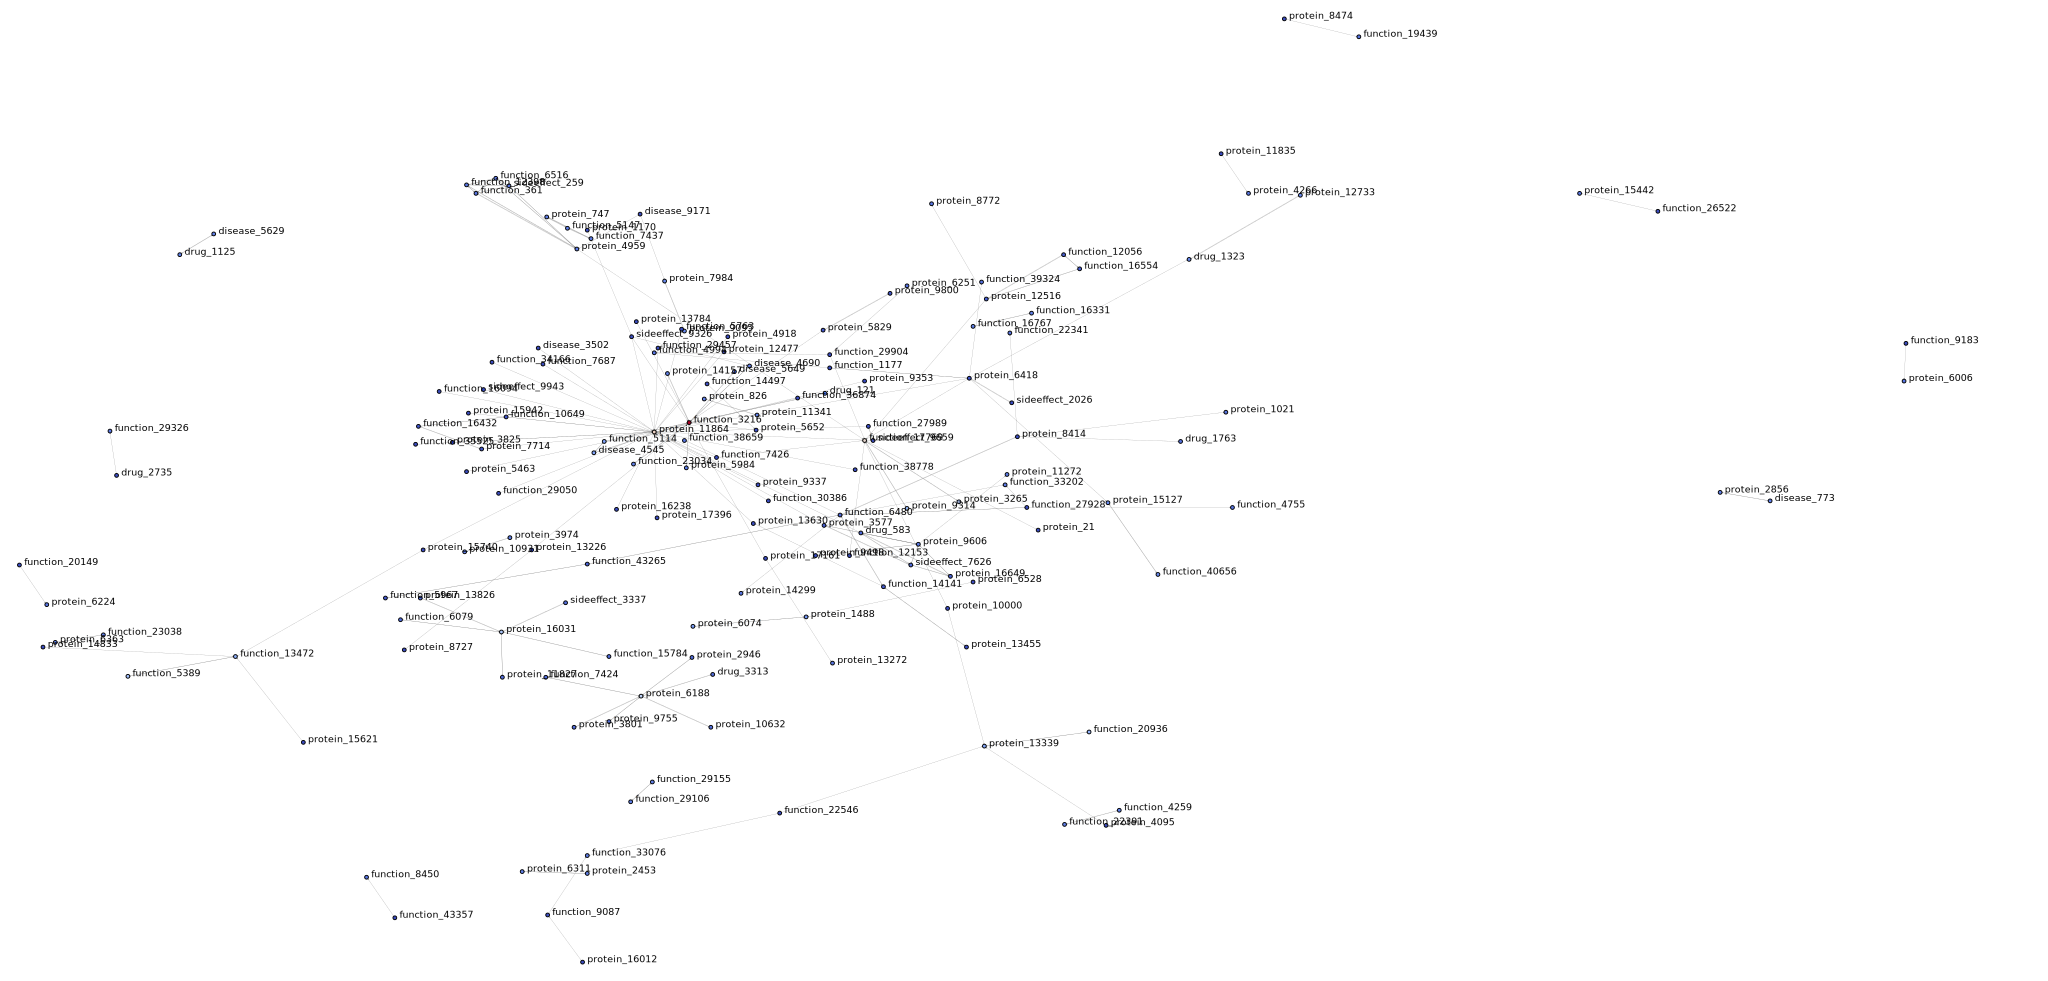

In [16]:
draw_graph(nx.k_core(biokg_sample, 1), show_names=True, node_size=2, edge_width=0.2)

In [17]:
degrees = dict(nx.degree(biokg_sample))

In [18]:
degcent = nx.degree_centrality(G)

In [ ]:
clustering_df = pd.DataFrame(nx.clustering(G), index=[0]).T
clustering_df.columns = ['clustering']
clustering_df.head()

In [20]:
degcent_df = pd.DataFrame(degcent, index=[0]).T
degcent_df.columns = ['degree_centrality']
degcent_df.sort_values('degree_centrality', inplace=True,
ascending=False)
degcent_df.head(20)

,degree_centrality
function_6146,0.668995
function_5973,0.550484
function_3,0.549759
function_31761,0.308376
function_7780,0.290588
function_2789,0.286184
function_27811,0.279732
function_23031,0.277610
function_27816,0.226155
function_27813,0.210639


In [ ]:
import matplotlib.pyplot as plt
_= degcent_df[0:20].plot.barh(figsize=(12,7))
plt.gca().invert_yaxis()

In [ ]:
betwcent = nx.betweenness_centrality(G)

In [ ]:
betwcent_df = pd.DataFrame(betwcent, index=[0]).T
betwcent_df.columns = ['betweenness_centrality']
betwcent_df.sort_values('betweenness_centrality',
inplace=True, ascending=False)
betwcent_df.head(20)

In [ ]:
title = 'Top 20 Betweenness Centrality'
_= betwcent_df[0:20].plot.barh(title=title,
figsize=(12,7))
plt.gca().invert_yaxis()

In [ ]:
pagerank = nx.pagerank(G)

In [ ]:
pagerank_df = pd.DataFrame(pagerank, index=[0]).T
pagerank_df.columns = ['pagerank']
pagerank_df.sort_values('pagerank', inplace=True,
ascending=False)
pagerank_df.head(20)

In [ ]:
title = 'Top 20 Node by Page Rank'
_= pagerank_df[0:20].plot.barh(title=title,
figsize=(12,7))
plt.gca().invert_yaxis()

In [21]:
import community as community_louvain

In [22]:
def draw_partition(G, partition):
    import matplotlib.cm as cm
    import matplotlib.pyplot as plt
    # draw the graph
    plt.figure(3,figsize=(12,12))
    pos = nx.spring_layout(G)
    # color the nodes according to their partition
    cmap = cm.get_cmap('jet', max(partition.values()) +1)
    nx.draw_networkx_nodes(G, pos, partition.keys(),
    node_size=40, cmap=cmap, node_color = list(partition.values()))
    nx.draw_networkx_edges(G, pos, alpha=0.5, width = 0.3)
    return plt.show()

/tmp/ipykernel_30/667368384.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('jet', max(partition.values()) +1)


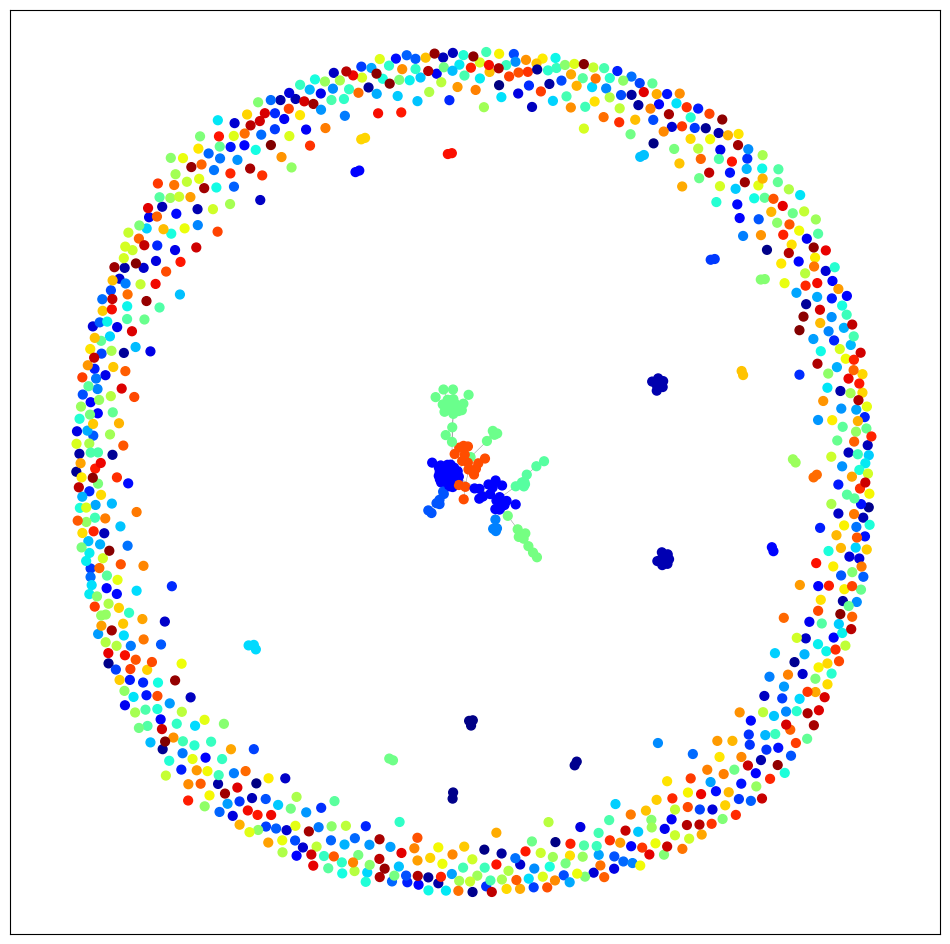

In [72]:
# Chuyển đổi sang đồ thị vô hướng  
G_undirected = biokg_sample.to_undirected()
partition = community_louvain.best_partition(G_undirected, resolution=1)
draw_partition(G_undirected, partition)

In [90]:
from networkx.algorithms.community.label_propagation import label_propagation_communities
communities = label_propagation_communities(G_undirected)
communities = list(communities)
comm_df = pd.DataFrame(communities)
filtered_df = comm_df[comm_df.iloc[:, 1:].notna().sum(axis=1) > 2]  
filtered_df

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
17,protein_13226,protein_11341,protein_14833,protein_12477,protein_11835,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
35,function_29326,function_29155,function_7437,function_20149,function_29050,function_7426,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
38,function_22546,function_38778,function_4994,function_16767,function_38659,function_4755,function_29457,None,None,None,...,None,None,None,None,None,None,None,None,None,None
60,protein_5829,protein_11272,protein_8772,protein_9095,protein_4266,protein_8414,protein_3265,protein_13455,protein_12516,protein_9353,...,protein_7984,protein_16238,protein_14157,protein_13339,protein_15621,protein_15442,protein_6418,protein_13784,protein_6363,protein_11827
70,function_33076,function_39324,protein_2946,protein_6224,function_33202,protein_1488,protein_14299,None,None,None,...,None,None,None,None,None,None,None,None,None,None
98,function_7424,function_26522,protein_1170,protein_9606,function_7687,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
179,protein_6311,protein_9314,protein_747,function_29904,protein_10632,protein_826,protein_10000,None,None,None,...,None,None,None,None,None,None,None,None,None,None
211,drug_1323,sideeffect_9659,drug_3313,sideeffect_7626,sideeffect_2026,sideeffect_3337,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
213,sideeffect_259,drug_1125,sideeffect_9943,sideeffect_9326,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
263,function_6079,function_5763,function_6480,function_1177,function_43265,function_16331,function_6516,function_17769,protein_21,protein_8474,...,None,None,None,None,None,None,None,None,None,None


,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
17,protein_13226,protein_11341,protein_14833,protein_12477,protein_11835,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
35,function_29326,function_29155,function_7437,function_20149,function_29050,function_7426,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
38,function_22546,function_38778,function_4994,function_16767,function_38659,function_4755,function_29457,None,None,None,...,None,None,None,None,None,None,None,None,None,None
60,protein_5829,protein_11272,protein_8772,protein_9095,protein_4266,protein_8414,protein_3265,protein_13455,protein_12516,protein_9353,...,protein_7984,protein_16238,protein_14157,protein_13339,protein_15621,protein_15442,protein_6418,protein_13784,protein_6363,protein_11827
70,function_33076,function_39324,protein_2946,protein_6224,function_33202,protein_1488,protein_14299,None,None,None,...,None,None,None,None,None,None,None,None,None,None
98,function_7424,function_26522,protein_1170,protein_9606,function_7687,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
179,protein_6311,protein_9314,protein_747,function_29904,protein_10632,protein_826,protein_10000,None,None,None,...,None,None,None,None,None,None,None,None,None,None
211,drug_1323,sideeffect_9659,drug_3313,sideeffect_7626,sideeffect_2026,sideeffect_3337,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
213,sideeffect_259,drug_1125,sideeffect_9943,sideeffect_9326,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
263,function_6079,function_5763,function_6480,function_1177,function_43265,function_16331,function_6516,function_17769,protein_21,protein_8474,...,None,None,None,None,None,None,None,None,None,None


In [86]:
communities[35]

{'function_20149',
 'function_29050',
 'function_29155',
 'function_29326',
 'function_7426',
 'function_7437'}

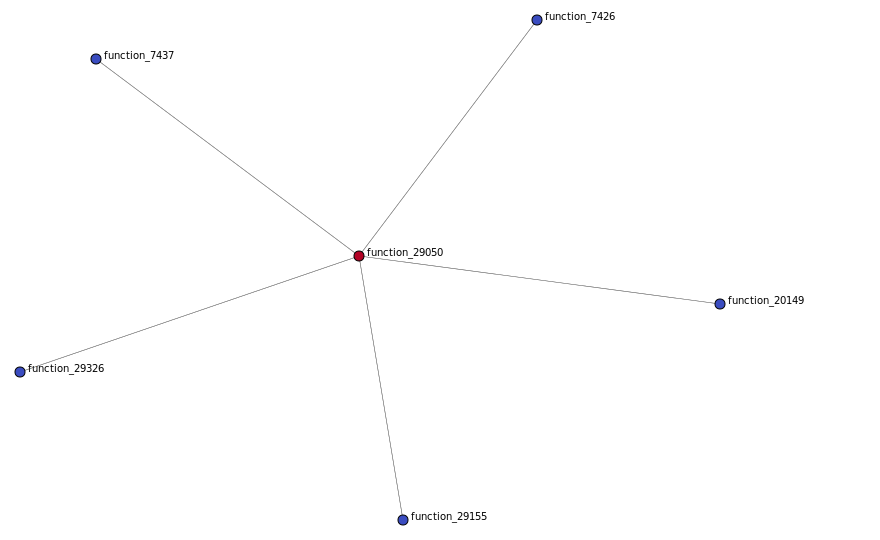

In [89]:
community = communities[35]
G_community = G_undirected.subgraph(community)
draw_graph(G_community, show_names=True, node_size=5)

In [92]:
from networkx.algorithms.community import girvan_newman

In [131]:
G_undirected1 = biokg_sub.to_undirected()
communities1 = girvan_newman(G_undirected1)
communities1= list(communities1)

In [132]:
comm_df = pd.DataFrame(communities1)
filtered_df = comm_df[comm_df.iloc[:, 1:].notna().sum(axis=1) > 2]  
filtered_df

,0,1,2,3,4,5,6,7,8
2,{function_6079},{function_5763},{function_6480},"{function_1177, function_43265, function_6516,...",None,None,None,None,None
3,{function_6079},{function_5763},{function_6480},"{function_1177, function_6516, function_17769,...",{function_43265},None,None,None,None
4,{function_6079},{function_5763},{function_6480},"{function_17769, function_30386, function_2303...",{function_43265},{function_6516},None,None,None
5,{function_6079},{function_5763},{function_6480},"{function_30386, function_23038, function_1177}",{function_43265},{function_6516},{function_17769},None,None
6,{function_6079},{function_5763},{function_6480},{function_1177},{function_43265},{function_6516},{function_17769},"{function_30386, function_23038}",None
7,{function_6079},{function_5763},{function_6480},{function_1177},{function_43265},{function_6516},{function_17769},{function_23038},{function_30386}


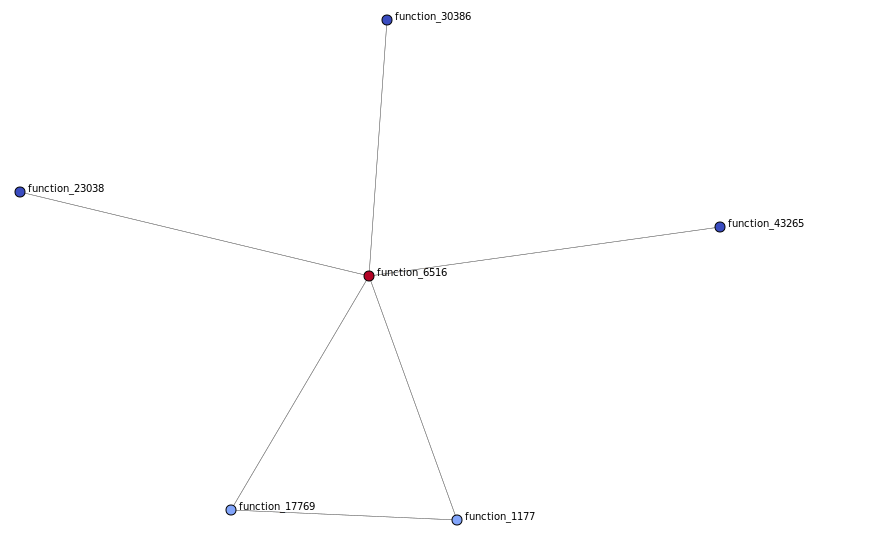

In [143]:
community1 = communities1[2]
community1= community1[3]
G_community1 = G_undirected.subgraph(community1)
draw_graph(G_community1, show_names=True, node_size=5)